In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import seaborn as sns
# sns.set(color_codes = True)
%matplotlib inline

In [4]:
jtplot.style(theme='monokai')

# Data Importing and Cleaning

### Chart Data

In [184]:
chart_df = pd.read_csv('../data/all_charts.csv')
chart_df = chart_df[['chartDate', 
                     'title', 
                     'artist', 
                     'peakPos', 
                     'lastPos',
                     'weeks',
                     'rank',
                     'change',
                     'spotifyID']]
chart_df['chartDate'] = pd.to_datetime(chart_df[('chartDate')])
chart_df['year'] = chart_df['chartDate'].dt.year
chart_df['month'] = chart_df['chartDate'].dt.month
chart_df['decade'] = (chart_df.chartDate.dt.year//10)*10
chart_df['rank_weight'] = 101 - chart_df['rank'] 

/Users/AndrewKraemer/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (18,19,20,21,22,23,24,25,26,27,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [275]:
# Only keep top 10
chart_df = chart_df[chart_df['rank'] < 11]

### Spotify Data

In [276]:
spotify_df = pd.read_csv('../data/spotify_data.csv')
spotify_df = spotify_df.drop_duplicates() # remove one spotify dup
spotify_df['maj_minor'] = spotify_df['key_mode'].str.split(' ', 1).str[1]

### Lyrics Data

#### Import and clean data

In [277]:
lyrics_df = pd.read_csv('../data/lyrics.csv')
lyrics_df = lyrics_df[lyrics_df['Source'].notnull()] # remove songs without lyrics

In [278]:
# Create TextBlob object. Extract polarity score
from textblob import TextBlob
lyrics_df['tb_obj'] = lyrics_df['Lyrics'].apply(lambda lyric: TextBlob(lyric)) # takes a bit to run
lyrics_df['polarity'] = lyrics_df['tb_obj'].apply(lambda tb_obj: tb_obj.sentiment.polarity)
lyrics_df['polarity'] = lyrics_df['polarity'].apply(lambda x: (x + 1) / 2) # converts (-1,1) score to (0,1)

#### Word Analysis

In [279]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english', max_features=5000)
vectorized = cv.fit_transform(lyrics_df['Lyrics'])
words = cv.get_feature_names()

word_counts = pd.DataFrame.from_dict({word: vectorized.getcol(idx).sum() for word, idx in cv.vocabulary_.items()}, orient='index').reset_index()
word_counts.columns = ['word', 'count'] # rename columns

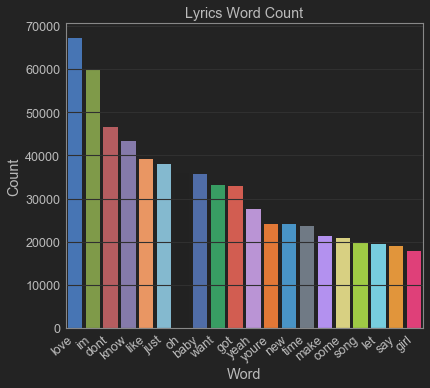

In [280]:
top_words = word_counts.sort_values('count', ascending = False).head(20)
sns.barplot(x = 'word', 
            y = 'count', data = top_words )
plt.xlabel('Word')
plt.ylabel('Count')
plt.xticks(rotation=40, ha = 'right')
plt.title('Lyrics Word Count')
plt.show()

### Join Data

In [281]:
df = pd.merge(chart_df, spotify_df, left_on='spotifyID', right_on = 'track_uri', how='inner')
df = pd.merge(df, lyrics_df, left_on='spotifyID', right_on = 'spotifyID', how='inner')

#### Analysis

In [282]:
import operator
def quick_filter(df, bort, peak_pos_thresh = 5):        
    """
    Function quickly subsets the data for quick data searches & avoids making temporary dataframes
    It's not perfect but it's quick and helpful
    """
    spot_flds = ['chartDate', 'title', 'artist', 'peakPos', 'valence', 'energy', 'polarity', 'happy_index']
    return df[bort & (df['peakPos'] < 5)][spot_flds].drop_duplicates(subset = ['title', 'artist'])

In [283]:
# Examples for valence v energy plot below

# quick_filter(df, (df['valence'] < .2) & (df['energy'] < .2))
# Can You Feel The Love Tonight by Elton John (142471)

# quick_filter(df, (df['valence'] > .8) & (df['energy'] < .4))
# Bang Bang (My Baby Shot Me Down) nancy sinatra

# quick_filter(df, (df['valence'] > .8) & (df['energy'] > .8))
# surfin usa beach boys, splish splash, if I had a hammer, timber pitbull + kesha, hey yah outcast

# quick_filter(df, (df['valence'] < .3) & (df['energy'] > .8))
# Like A Prayer	Madonna, My Sacrifice Creed

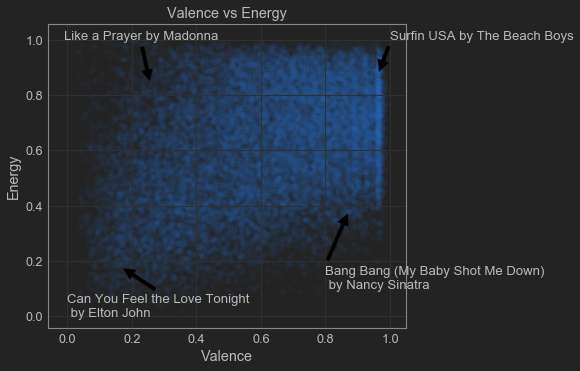

In [284]:
# Show off the differences 
plt.scatter(spotify_df['valence'], spotify_df['energy'], alpha = .05)
plt.title('Valence vs Energy')
plt.xlabel('Valence')
plt.ylabel('Energy')
plt.annotate('Like a Prayer by Madonna', xy=(0.2570, 0.842), xytext = (-.01,1), 
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Surfin USA by The Beach Boys', xy=(0.964, 0.878), xytext = (1,1), 
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Bang Bang (My Baby Shot Me Down) \n by Nancy Sinatra', xy=(0.873, 0.382), xytext = (.8,.1), 
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Can You Feel the Love Tonight \n by Elton John', xy=(0.1670, 0.1790), xytext = (0,0), 
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

In [285]:
# quick_filter(df, (df['polarity'] < .4))
# Bridge Over Troubled Water \n by Simon & Garfunkel

# quick_filter(df, (df['polarity'] > .65))
# You're Beautiful by James Blunt

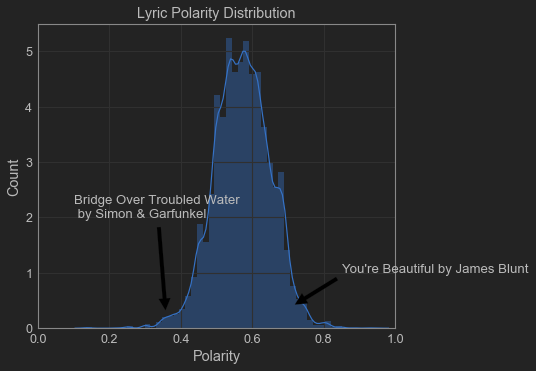

In [286]:
sns.distplot(df['polarity']) #kde = False
plt.title('Lyric Polarity Distribution')
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.xlim(0, 1)
plt.annotate('Bridge Over Troubled Water \n by Simon & Garfunkel', 
             xy=(0.358322, 0.236), 
             xytext = (.1, 2), 
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate("You're Beautiful by James Blunt", 
             xy=(0.712690,.4), 
             xytext = (.85, 1), 
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

Create Happy_Index by combining *valence* and *energy* from Spotify with the *polarity* of the Lyrics -- while normalizing. 

In [287]:
from sklearn.metrics.pairwise import euclidean_distances
coord = df['coord'] =[[df['valence'].iloc[i], df['energy'].iloc[i]] for i in range(df.shape[0])]
df['euclidean_dist'] = euclidean_distances(coord, [[0, 0]])

df['euc_dist_normed'] = df['euclidean_dist'] / (2**(1/2)) # euclidian dist between (0,0) & (1,1)
df['happy_index'] = (df['euc_dist_normed'] + df['polarity'])/2

In [288]:
# quick_filter(df, (df['happy_index'] < .4))
# Without You \n by Harry Nilsson 0.396429

# quick_filter(df, (df['happy_index'] > .8))
# I Feel Fine by The Beatles  0.817876

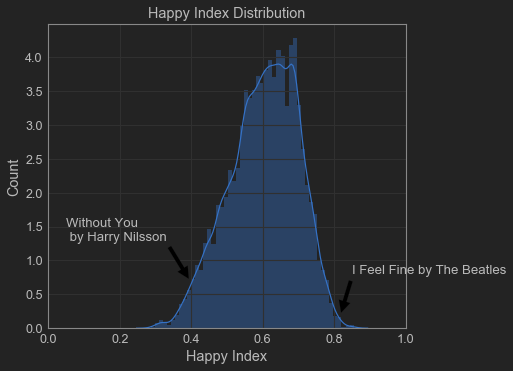

In [289]:
sns.distplot(df['happy_index']) #kde = False
plt.title('Happy Index Distribution')
plt.xlabel('Happy Index')
plt.ylabel('Count')
plt.xlim(0, 1)
plt.annotate('Without You \n by Harry Nilsson', 
             xy=(0.396429, 0.7), 
             xytext = (.05, 1.3), 
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate("I Feel Fine by The Beatles", 
             xy=(0.817876,.2), 
             xytext = (.85, .8), 
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

#### By Year

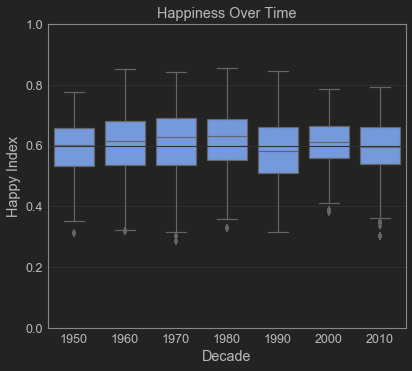

In [290]:
sns.boxplot(x = 'decade', y = 'happy_index', data = df,
            color = '#6495ED')
plt.title('Happiness Over Time')
plt.xlabel('Decade')
plt.ylabel('Happy Index')
plt.ylim(0, 1)
plt.show()

#### Missing Data

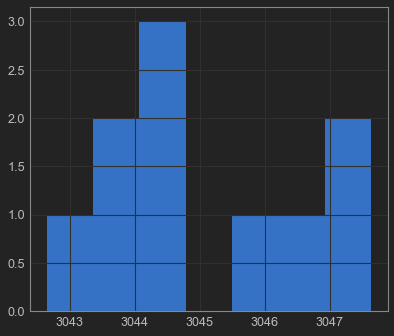

All years originally had between 3043 and 3048 instances, which checks out 


In [291]:
chart_df.groupby('rank')['year'].count().reset_index(name = 'count')['count'].hist(bins = 7, align = 'left')
plt.show()
print('All years originally had between 3043 and 3048 instances, which checks out ')

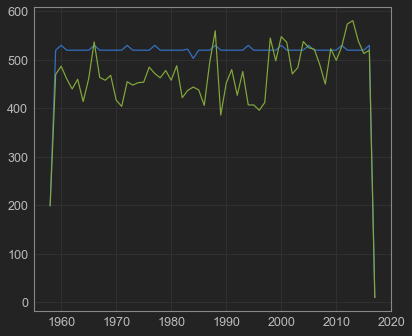

All chart totals: 30455 
Merged Dataset: 27733 
Percent Coverage: 91.06%


In [292]:
chart_year = chart_df.groupby('year')['rank'].count().reset_index(name = 'count')
df_year = df.groupby('year')['rank'].count().reset_index(name = 'count')
plt.plot(chart_year['year'], chart_year['count'])
plt.plot(df_year['year'], df_year['count'])
plt.show()
print('All chart totals: ' + str(chart_year['count'].sum()), 
      '\nMerged Dataset: ' + str(df_year['count'].sum()),
      '\nPercent Coverage: ' + str(round(df_year['count'].sum() / chart_year['count'].sum()*100,2)) + '%')

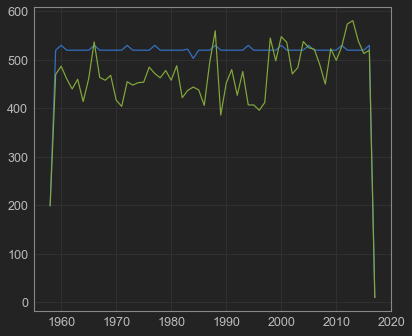

All chart totals: 30455 
Merged Dataset: 27733 
Percent Coverage: 91.06%


In [293]:
chart_year_10 = chart_df[chart_df['rank'] < 11].groupby('year')['rank'].count().reset_index(name = 'count')
df_year_10 = df[df['rank'] < 11].groupby('year')['rank'].count().reset_index(name = 'count')
plt.plot(chart_year_10['year'], chart_year_10['count'])
plt.plot(df_year_10['year'], df_year_10['count'])
plt.show()
print('All chart totals: ' + str(chart_year_10['count'].sum()), 
      '\nMerged Dataset: ' + str(df_year_10['count'].sum()),
      '\nPercent Coverage: ' + str(round(df_year_10['count'].sum() / chart_year_10['count'].sum()*100,2)) + '%')

## add in external predictors

Group Bilboard to Month

In [294]:
df_month = df.groupby(['year', 'month', 'decade'])[['happy_index', 'valence', 'energy', 'polarity']].mean().reset_index()

Import SnP and clean

In [295]:
snp_df = pd.read_csv('../data/daily_snp500.csv')
snp_df['Date'] = pd.to_datetime(snp_df[('Date')])
snp_df['year'] = snp_df['Date'].dt.year
snp_df['month'] = snp_df['Date'].dt.month
snp_df['Mid'] = (snp_df['High'] + snp_df['Low'])/2

In [296]:
# aggregate snp
snp_h = snp_df.groupby(['year', 'month'])['High'].max().reset_index(name = 'snp_high')
snp_l = snp_df.groupby(['year', 'month'])['Low'].min().reset_index(name = 'snp_low').drop(['year', 'month'], axis = 1)
snp_m = snp_df.groupby(['year', 'month'])['Mid'].mean().reset_index(name = 'snp_mid').drop(['year', 'month'], axis = 1)
snp_vol = snp_df.groupby(['year', 'month'])['Volume'].sum().reset_index(name = 'snp_vol').drop(['year', 'month'], axis = 1)
snp_month_df = pd.concat([snp_h, snp_l, snp_m, snp_vol], axis=1)
print(snp_h.shape[0], snp_l.shape[0], snp_m.shape[0], snp_vol.shape[0])

816 816 816 816


In [297]:
# merge snp with music data
df_month = pd.merge(df_month, snp_month_df)

Import CCI

In [298]:
# import consumer confidence index
cci_df = pd.read_csv('../data/cci.csv')
# only keep important information
cci_df = cci_df[cci_df['LOCATION'] == 'USA'][['TIME', 'Value']]
cci_df['TIME'] = pd.to_datetime(cci_df['TIME'])
cci_df['month'] = cci_df['TIME'].dt.month
cci_df['year'] = cci_df['TIME'].dt.year
cci_df = cci_df.rename(index=str, columns = {'Value': 'cci_value'})
cci_df = cci_df.drop('TIME', axis = 1)

In [299]:
# merge cci with music data
df_month = pd.merge(df_month, cci_df)

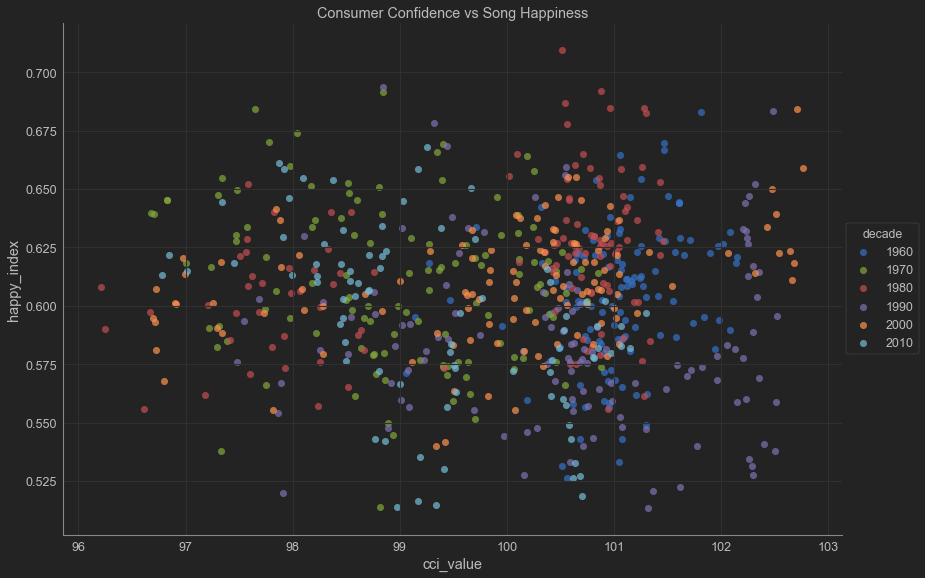

In [300]:
# sns.regplot(x="cci_value", y="happy_index", data=df_month)
sns.lmplot(x = "cci_value", 
            y = "happy_index", 
            data = df_month,
            fit_reg = False, hue = 'decade', size=8, aspect=1.5, scatter_kws={'alpha':0.7,"s": 50})
plt.title('Consumer Confidence vs Song Happiness')
plt.show()

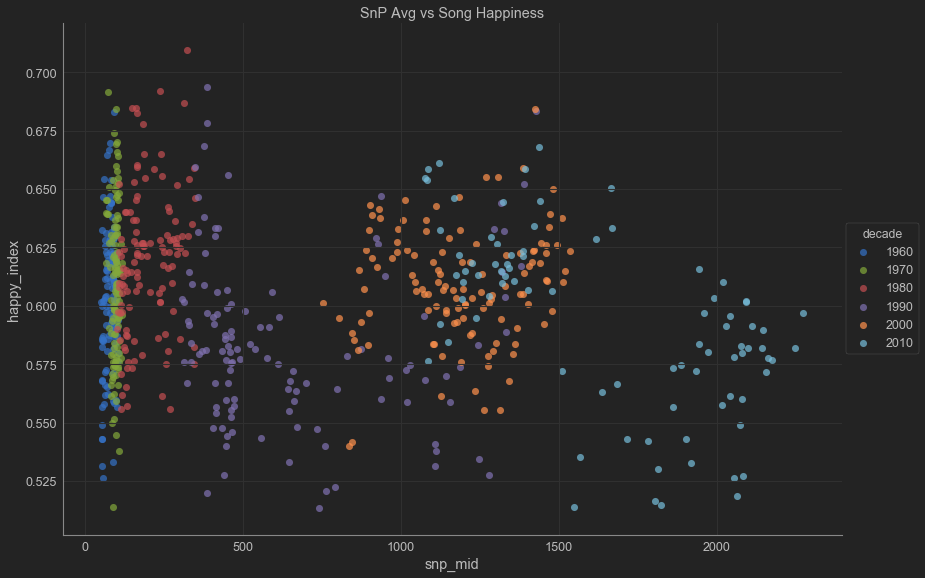

In [301]:
sns.lmplot(x="snp_mid", 
           y="happy_index", 
           data=df_month, 
           fit_reg = False, hue = 'decade', size=8, aspect=1.5, scatter_kws={'alpha':0.7,"s": 50})

plt.title('SnP Avg vs Song Happiness')
plt.show()